# Simulation to generate maps for SO. 

#### The outputs of the simulation will be used to run the `BBPipe` pipeline with `PySM`. 

The following code replaces generate_SO_maps.py (.../BBPipe/examples/generate_SO_maps.py), i.e. the aim is to integrate the BBPipe package with PySM. 

PySM v2 is used. There are two main modules to import when using PySM, `pysm` and `models`:

In [41]:
import pysm
from pysm.nominal import models

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from noise_calc import Simons_Observatory_V3_SA_noise,Simons_Observatory_V3_SA_beams # /Users/susannaazzoni/Desktop/Software/BBPipe/examples/noise_calc.py
import warnings
warnings.simplefilter("ignore")

### Generate components with different templates for spectral indices and amplitudes

In [42]:
nside = 64

PySM defines parameters for each model. 
For example, if we set the sky configuration to include only dust in the dictionary `sky_config = {'dust' : models("d2", nside)}` and then running `print (sky_config)` will show the parameters that are set by default. If we want to change these parameters, the following can be done.

Select models for each component:

In [43]:
d2 = models("d2", nside) # dust: modified black body model 
s1 = models("s1", nside) # synchrotron: simple power law with no curved index (curvature = 0)
c1 = models("c1", nside) # cmb: lensed CMB realisation computed using Taylens

Modify models:

In [44]:
# Dust
A_dust_BB=5.0
EB_dust=2.  # ratio between B and E modes from Planck IX 2018, B_to_E = 0.5, i.e. E_to_B=2
alpha_dust_EE=-0.42 # spectral tilt from Planck IX 2018, alpha = -0.42
alpha_dust_BB=-0.2
nu0_dust=353. #corresponds to nu_0_P' : 353. # Set as default for d2
beta_dust = 1.59 # spectral index and temperature from Planck IX 2018, beta = 1.53, T=19.6 K
temp_dust = 19.6

#Synchrotron:
A_sync_BB=2.0
EB_sync=2.
alpha_sync_EE=-0.6
alpha_sync_BB=-0.4
nu0_sync=23. #nu_0_P # Set as default
beta_sync=-3. # spectral index 

def fcmb(nu):
    x=0.017608676067552197*nu
    ex=np.exp(x)
    return ex*(x/(ex-1))**2

A_sync_BB = A_sync_BB * fcmb(nu0_sync)**2
A_dust_BB = A_dust_BB * fcmb(nu0_dust)**2

In a future version, the idea is to modify the beta parameter of both from constant to gaussian, to express a function changing in space.

### Calculate power spectrum

Define the range of $\ell$s:

In [45]:
lmax = 3*nside-1
ells = np.arange(lmax+1)

Sometimes, instead of $C_{\ell}$, $D_{\ell} = \frac{\ell (\ell + 1)}{2 \pi} C_{\ell}$ is used as it changes more slowly as a function of $\ell$. We define the factor to transform between $D_{\ell}$ and $C_{\ell}$:

In [46]:
dlfac=2*np.pi/(ells*(ells+1.)); dlfac[0]=1

The Gaussian power spectrum : $ C_{\ell} = A \cdot (\frac{\ell+0.001}{80.})^\alpha $.
Term 0.001 is added to avoid dividing by zero. 

In [47]:
# Dust
dl_dust_bb = A_dust_BB * ((ells+0.001) / 80.)**alpha_dust_BB 
dl_dust_ee = EB_dust * A_dust_BB * ((ells+0.001) / 80.)**alpha_dust_EE
cl_dust_bb = dl_dust_bb * dlfac
cl_dust_ee = dl_dust_ee * dlfac
cl_dust_tt = 0 * cl_dust_bb
cl_dust_tb = 0 * cl_dust_bb
cl_dust_eb = 0 * cl_dust_bb
cl_dust_te = 0 * cl_dust_bb

# Sync
dl_sync_bb = A_sync_BB * ((ells+0.001) / 80.)**alpha_sync_BB 
dl_sync_ee = EB_sync * A_sync_BB * ((ells+0.001) / 80.)**alpha_sync_EE
cl_sync_bb = dl_sync_bb * dlfac
cl_sync_ee = dl_sync_ee * dlfac
cl_sync_tt = 0 * cl_sync_bb
cl_sync_tb = 0 * cl_sync_bb
cl_sync_eb = 0 * cl_sync_bb
cl_sync_te = 0 * cl_sync_bb

# CMB
#l,dtt,dee,dbb,dte=np.loadtxt("/mnt/zfsusers/susanna/camb_lens_nobb.dat",unpack=True)
l,dtt,dee,dbb,dte=np.loadtxt("/Users/susannaazzoni/Desktop/Software/PySM_public/examples/data/camb_lens_nobb.dat",unpack=True)

#select first ell from 0 not 1                                                                                                                                    
l=l.astype(int)
msk=l<=lmax
l=l[msk]

dltt=np.zeros(len(ells)); dltt[ells]=dtt[ells]
dlee=np.zeros(len(ells)); dlee[ells]=dee[ells]
dlbb=np.zeros(len(ells)); dlbb[ells]=dbb[ells]
dlte=np.zeros(len(ells)); dlte[ells]=dte[ells] 
cl_cmb_bb=dlbb*dlfac
cl_cmb_ee=dlee*dlfac
cl_cmb_tt = 0 * cl_cmb_bb
cl_cmb_tb = 0 * cl_cmb_bb
cl_cmb_eb = 0 * cl_cmb_bb
cl_cmb_te = 0 * cl_cmb_bb

Write $C_{\ell}$ outputs to file:

In [48]:
'''
prefix_out="/mnt/extraspace/susanna/SO/Pysm-test"

np.savetxt(prefix_out + "/cls_cmb.txt",np.transpose([ells, cl_cmb_ee, cl_cmb_bb, cl_cmb_tt]))
np.savetxt(prefix_out + "/cls_sync.txt",np.transpose([ells, cl_sync_ee, cl_sync_bb, cl_sync_tt]))
np.savetxt(prefix_out + "/cls_dust.txt",np.transpose([ells, cl_dust_ee, cl_dust_bb, cl_dust_tt]))
'''
prefix_out="/Users/susannaazzoni/Desktop/Software/PySM_public/pip-test-outp"

np.savetxt(prefix_out + "/cls_cmb.txt",np.transpose([ells, cl_cmb_ee, cl_cmb_bb, cl_cmb_tt]))
np.savetxt(prefix_out + "/cls_sync.txt",np.transpose([ells, cl_sync_ee, cl_sync_bb, cl_sync_tt]))
np.savetxt(prefix_out + "/cls_dust.txt",np.transpose([ells, cl_dust_ee, cl_dust_bb, cl_dust_tt]))

Generate amplitude maps with `hp.synfast`:

In [49]:
# Dust
A_I_dust,A_Q_dust,A_U_dust = hp.synfast([cl_dust_tt, cl_dust_ee, cl_dust_bb, cl_dust_te],
                        nside=nside) #since cl_tt = 0, A_I will be zeros
# Sync
A_I_sync,A_Q_sync,A_U_sync = hp.synfast([cl_sync_tt, cl_sync_ee, cl_sync_bb, cl_sync_te],
                        nside=nside)
# cmb
A_I_cmb,A_Q_cmb,A_U_cmb = hp.synfast([cl_cmb_tt, cl_cmb_ee, cl_cmb_bb, cl_cmb_te],
                        nside=nside)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


Set the newly defined attributes in models:

In [50]:
# Dust
d2[0]['A_I'] = A_I_dust
d2[0]['A_Q'] = A_Q_dust
d2[0]['A_U'] = A_U_dust
d2[0]['spectral_index'] = beta_dust
d2[0]['temp'] = temp_dust * np.ones(d2[0]['temp'].size) #need array, no const value for temp with PySM

# Sync
s1[0]['A_I'] = A_I_sync
s1[0]['A_Q'] = A_Q_sync
s1[0]['A_U'] = A_U_sync
s1[0]['spectral_index'] = beta_sync

# cmb
c1[0]['A_I'] = A_I_cmb
c1[0]['A_Q'] = A_Q_cmb
c1[0]['A_U'] = A_U_cmb

#### Plot the new templates (maps of Q U amplitudes) in RJ unit:

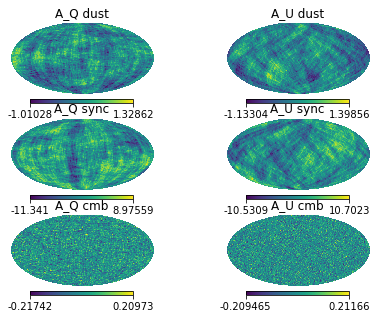

In [51]:
plt.figure()
# Dust
hp.mollview(A_Q_dust, title = 'A_Q dust', sub = (321)) # 3 rows 2 columns
hp.mollview(A_U_dust, title = 'A_U dust', sub = (322))
# Sync
hp.mollview(A_Q_sync, title = 'A_Q sync', sub = (323))
hp.mollview(A_U_sync, title = 'A_U sync', sub = (324))
# cmb
hp.mollview(A_Q_cmb, title = 'A_Q cmb', sub = (325))
hp.mollview(A_U_cmb, title = 'A_U cmb', sub = (326))

plt.show()

#### Plot I Q U maps of each components over total sky with PySM

Define configuration dictionaries for each component, using the previously defined models.

In [52]:
sky_config = {   
'dust' : d2,
'synchrotron' : s1,
'cmb' : c1}

Initialise Sky:

In [53]:
sky = pysm.Sky(sky_config)

Define components for array of frequencies:

In [54]:
nu = np.array([27., 39., 93., 145., 225., 280.]) # elements [0,1,2,3,4,5]

dust = sky.dust(nu)
sync = sky.synchrotron(nu)
cmb = sky.cmb(nu)

Plot dust:

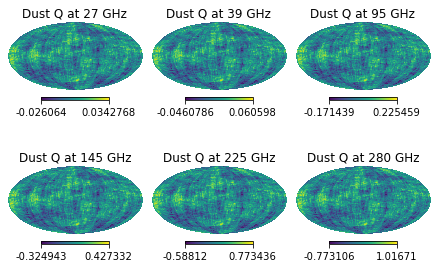

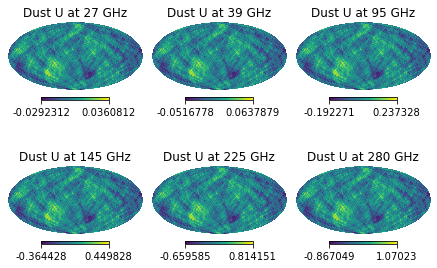

In [55]:
'''
No need to plot I as amplitude is zero
#dust[a,b,c], a = nu[0=10, 1=100, etc], b = [I,Q,U] 
#sub=(331) i.e.  3 rows 3 columns 1st element
'''
#fix Q
plt.figure() 
hp.mollview(dust[0,1,:], title = 'Dust Q at 27 GHz', sub = (231)) 
hp.mollview(dust[1,1,:], title = 'Dust Q at 39 GHz', sub = (232)) 
hp.mollview(dust[2,1,:], title = 'Dust Q at 95 GHz', sub = (233))
hp.mollview(dust[3,1,:], title = 'Dust Q at 145 GHz', sub = (234))
hp.mollview(dust[4,1,:], title = 'Dust Q at 225 GHz', sub = (235))
hp.mollview(dust[5,1,:], title = 'Dust Q at 280 GHz', sub = (236))
#fix U
plt.figure() 
hp.mollview(dust[0,2,:], title = 'Dust U at 27 GHz', sub = (231)) 
hp.mollview(dust[1,2,:], title = 'Dust U at 39 GHz', sub = (232)) 
hp.mollview(dust[2,2,:], title = 'Dust U at 95 GHz', sub = (233))
hp.mollview(dust[3,2,:], title = 'Dust U at 145 GHz', sub = (234))
hp.mollview(dust[4,2,:], title = 'Dust U at 225 GHz', sub = (235))
hp.mollview(dust[5,2,:], title = 'Dust U at 280 GHz', sub = (236))

plt.show()

Plot Synchrotron:

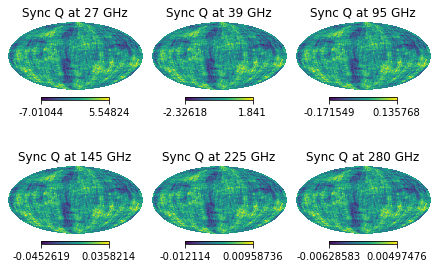

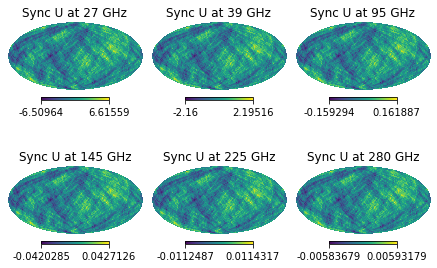

In [56]:
'''
No need to plot I as amplitude is zero
#sync[a,b,c], a = nu[0=10, 1=100, etc], b = [I,Q,U] 
#sub=(331) i.e.  3 rows 3 columns 1st element
'''
#fix Q
plt.figure()
hp.mollview(sync[0,1,:], title = 'Sync Q at 27 GHz', sub = (231))
hp.mollview(sync[1,1,:], title = 'Sync Q at 39 GHz', sub = (232))
hp.mollview(sync[2,1,:], title = 'Sync Q at 95 GHz', sub = (233))
hp.mollview(sync[3,1,:], title = 'Sync Q at 145 GHz', sub = (234))
hp.mollview(sync[4,1,:], title = 'Sync Q at 225 GHz', sub = (235))
hp.mollview(sync[5,1,:], title = 'Sync Q at 280 GHz', sub = (236))
#fix U
plt.figure()
hp.mollview(sync[0,2,:], title = 'Sync U at 27 GHz', sub = (231))
hp.mollview(sync[1,2,:], title = 'Sync U at 39 GHz', sub = (232))
hp.mollview(sync[2,2,:], title = 'Sync U at 95 GHz', sub = (233))
hp.mollview(sync[3,2,:], title = 'Sync U at 145 GHz', sub = (234))
hp.mollview(sync[4,2,:], title = 'Sync U at 225 GHz', sub = (235))
hp.mollview(sync[5,2,:], title = 'Sync U at 280 GHz', sub = (236))

plt.show()

Plot CMB:

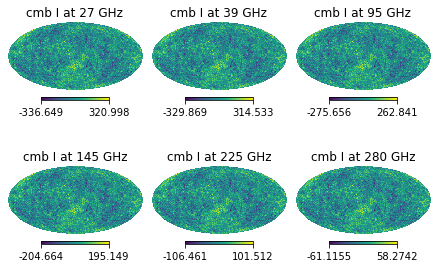

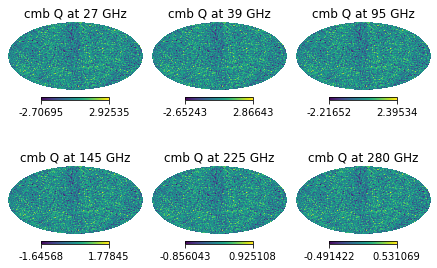

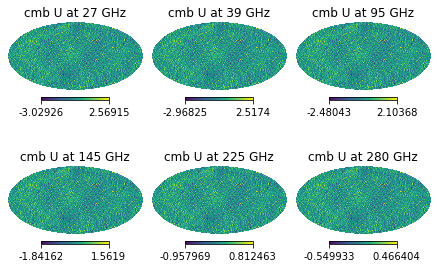

In [57]:
#fix I
plt.figure()
hp.mollview(cmb[0,0,:], title = 'cmb I at 27 GHz', sub = (231))
hp.mollview(cmb[1,0,:], title = 'cmb I at 39 GHz', sub = (232))
hp.mollview(cmb[2,0,:], title = 'cmb I at 95 GHz', sub = (233))
hp.mollview(cmb[3,0,:], title = 'cmb I at 145 GHz', sub = (234))
hp.mollview(cmb[4,0,:], title = 'cmb I at 225 GHz', sub = (235))
hp.mollview(cmb[5,0,:], title = 'cmb I at 280 GHz', sub = (236))
#fix Q
plt.figure()
hp.mollview(cmb[0,1,:], title = 'cmb Q at 27 GHz', sub = (231))
hp.mollview(cmb[1,1,:], title = 'cmb Q at 39 GHz', sub = (232))
hp.mollview(cmb[2,1,:], title = 'cmb Q at 95 GHz', sub = (233))
hp.mollview(cmb[3,1,:], title = 'cmb Q at 145 GHz', sub = (234))
hp.mollview(cmb[4,1,:], title = 'cmb Q at 225 GHz', sub = (235))
hp.mollview(cmb[5,1,:], title = 'cmb Q at 280 GHz', sub = (236))
#fix U
plt.figure()
hp.mollview(cmb[0,2,:], title = 'cmb U at 27 GHz', sub = (231))
hp.mollview(cmb[1,2,:], title = 'cmb U at 39 GHz', sub = (232))
hp.mollview(cmb[2,2,:], title = 'cmb U at 95 GHz', sub = (233))
hp.mollview(cmb[3,2,:], title = 'cmb U at 145 GHz', sub = (234))
hp.mollview(cmb[4,2,:], title = 'cmb U at 225 GHz', sub = (235))
hp.mollview(cmb[5,2,:], title = 'cmb U at 280 GHz', sub = (236))

plt.show()

Plot the Total signal:

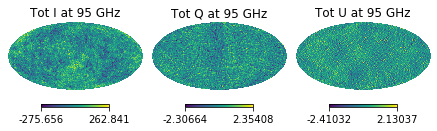

In [58]:
total = sky.signal()(nu) # T, Q, U
plt.figure()
# fix I
hp.mollview(total[2,0,:], title = 'Tot I at 95 GHz', sub = (131)) 
# fix Q
hp.mollview(total[2,1,:], title = 'Tot Q at 95 GHz', sub = (132))
#fix U
hp.mollview(total[2,2,:], title = 'Tot U at 95 GHz', sub = (133))

plt.show()

Evaluate the signal for a vector of frequencies and plot:

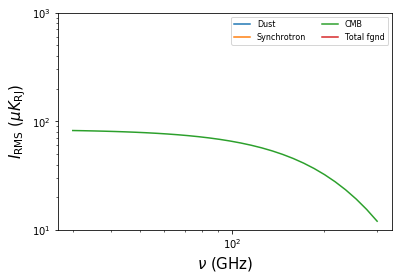

In [59]:
freqs = np.logspace(np.log10(30), np.log10(300), 30)
output = sky.signal()(freqs)

dust = np.std(sky.dust(freqs), axis = 2)
sync = np.std(sky.synchrotron(freqs), axis = 2)
cmb = np.std(sky.cmb(freqs), axis = 2)
total_fgnd = np.std(output - sky.cmb(freqs), axis = 2)

plt.figure()
plt.loglog(freqs, dust[:, 0], label = "Dust") #--> Intensity is zero, returns empty 
plt.loglog(freqs, sync[:, 0], label = "Synchrotron") #--> Intensity is zero, returns empty  
plt.loglog(freqs, cmb[:, 0], label = "CMB")
plt.loglog(freqs, total_fgnd[:, 0], label = "Total fgnd")
plt.legend(fontsize = 8, ncol = 2)
plt.xlabel(r"$\nu$ (GHz)", fontsize = 15)
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)", fontsize = 15)
plt.ylim([10, 1000])

plt.show()

### Add instrumental effects with PySM (beam and bpass)

We have 6 bandpasses for Simons Observatory (SO):

LF1 centred at 27 GHz 
LF2 centred at 39 GHz
MF1 centred at 93 GHz 
MF2 centred at 145 GHz
UHF1 centred at 225 GHz
UHF2 centred at 280 GHz

Bpasses and beams can be found e.g.    
examples/data/LF/LF1.txt #Bandpasses    
examples/beam_LF1.txt #beam

Import bandpasses:

In [60]:
freqs_LF1, bpass_LF1 = np.loadtxt("/Users/susannaazzoni/Desktop/Software/BBPipe/examples/data/LF/LF1.txt",unpack=True) 
freqs_LF2, bpass_LF2 = np.loadtxt("/Users/susannaazzoni/Desktop/Software/BBPipe/examples/data/LF/LF2.txt",unpack=True)
freqs_MF1, bpass_MF1 = np.loadtxt("/Users/susannaazzoni/Desktop/Software/BBPipe/examples/data/MF/MF1.txt",unpack=True)
freqs_MF2, bpass_MF2 = np.loadtxt("/Users/susannaazzoni/Desktop/Software/BBPipe/examples/data/MF/MF2.txt",unpack=True)
freqs_UHF1, bpass_UHF1 = np.loadtxt("/Users/susannaazzoni/Desktop/Software/BBPipe/examples/data/UHF/UHF1.txt",unpack=True)
freqs_UHF2, bpass_UHF2 = np.loadtxt("/Users/susannaazzoni/Desktop/Software/BBPipe/examples/data/UHF/UHF2.txt",unpack=True)

From the observed map 
\begin{equation*}
m^{obs}(\vec{x}) = \int dx' m(x') B(x - x')
\end{equation*}
we define the beam $B(x - x')$.

In Fourier Space the map corresponds to the spherical harmonics:
\begin{equation*}
a^{obs}_{\ell m} = a_{\ell m} b_{\ell}
\end{equation*}
where 
\begin{equation*}
b_{\ell} = e^{-\frac{1}{2} \ell (\ell + 1) \ \sigma^2} \ .
\end{equation*}
The factor $\sigma$ is defined as the Full Width Half Maximum (FWHM) of the beam,
\begin{equation*}
\sigma_{FWHM} = \frac{\lambda \cdot 1.22}{D}
\end{equation*}
where $D$ is the diameter of the telescope used. From this, we the gaussian beam is defined as 
\begin{equation*}
\sigma_{G} = \frac{\sigma_{FWHM}}{2.355} \ .
\end{equation*}

PySM currently only passes gaussian beams, so we input the $\sigma_{G}$ and it will calculate $b_l$ automatically. The input values are calculated knowing the diameter of the SAT (Small Aperture Telescope) of 42 cm and the centre frequency (f) of each bandpass, which leads to $\lambda = f / c $. The $\sigma_{G}$ is then converted from radians to arcminutes with the standard conversion, i.e. $(\sigma [arcmin]) = (\sigma [rad]) \cdot (60 \cdot 180)/\pi$.

The computed values can be found in the noise_calc module from BBPipe, and called as Simons_Observatory_V3_SA_beams():

In [61]:
beams = Simons_Observatory_V3_SA_beams() #already given in arcmin

The instrument is configured with PySM at this stage only to account for the effects of the beams and bandpasses, while the noise component will be added later (i.e. 'add_noise' : False). This is because the noise computed with PySM is convolved with the beam, and we want the noise to be deconvolved. Furthermore, since PySM works on total sky maps, a mask to account for the observed patches of the sky will be added at a later stage. 

In [62]:
instrument_config = {
    'nside' : nside,
    #'frequencies' : #Expected in GHz # not needed if use_bpass true
    'use_smoothing' : True,
    'beams' : beams, #Expected beam fwhm in arcmin #Only used if use_smoothing is True
    'add_noise' : False, 
    'sens_I' : None, #Expected in units uK_RJ #Only used if add_noise is True
    'sens_P' : None,  #channel sensitivities in uK_CMB amin #Only used if add_noise is True
    'noise_seed' : 1234,
    'use_bandpass' : True,
    'channels' : [(freqs_LF1, bpass_LF1), #frequencies and weights of channels 
                  (freqs_LF2, bpass_LF2), #to be calculated as a list of tuples
                  (freqs_MF1, bpass_MF1), # [(frequencies_1, weights_1), (frequencies_2, weights_2) ...]
                  (freqs_MF2, bpass_MF2), 
                  (freqs_UHF1, bpass_UHF1), 
                  (freqs_UHF2, bpass_UHF2)], 
    'channel_names' : ['LF1', 'LF2', 'MF1', 'MF2', 'UHF1', 'UHF2'],
    'output_units' : 'uK_RJ',
    'output_directory' : '/Users/susannaazzoni/Desktop/Software/PySM_public', #'/mnt/zfsusers/susanna/PySM-tests/test-outp-Pysm',
    'output_prefix' : 'test',
    'pixel_indices' : None, # added to dictionary for partial sky
}

sky = pysm.Sky(sky_config)

The pysm.pysm.Instrument object is used to integrate the signal over an arbitrary bandpass, smoothing with a Gaussian beam, and the addition of Gaussian white noise. As previously mentioned, here it is used only for the beam and the bpass.

In [63]:
instrument = pysm.Instrument(instrument_config)

This will write maps of (T, Q, U) as observed at the given frequencies with the given instrumental effects:

In [64]:
instrument.observe(sky)

Channel name | sigma_I (uK_CMB amin) | sigma_P (uK_CMB amin) | FWHM (arcmin) |
LF1 | 00.00 | 00.00 | 91.00 
LF2 | 00.00 | 00.00 | 63.00 
MF1 | 00.00 | 00.00 | 30.00 
MF2 | 00.00 | 00.00 | 17.00 
UHF1 | 00.00 | 00.00 | 11.00 
UHF2 | 00.00 | 00.00 | 09.00 


Then we want to read the generated maps of the sum of components including the instrumental effects at different bpasses (`sky_maps` corresponds to `maps_freqs` in `generate_SO_maps`):

In [65]:
sky_maps = [] #empty array
band_nm = ["L", "M", "UH"] # bandpasses names 
for n in range(len(band_nm)): 
    for i in range(2): # 2 frequencies per bpass name (LF, MF, UHF)
        print ("test_bandpass_{}F%d_total_nside0064.fits" 
               .format(band_nm[n]) # "{}".format(..[n]..) used for strings, select the bpass name
               % (i+1)) # "%d" %(..i) used for numbers, start i from 1 not zero
        mp = hp.read_map("test_bandpass_{}F%d_total_nside0064.fits".format(band_nm[n]) % (i+1), 
                         field=[1,2]) #field = [T,Q,U] = [0,1,2], only want Q,U
        sky_maps.append(mp)
sky_maps = np.array(sky_maps)

test_bandpass_LF1_total_nside0064.fits
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
test_bandpass_LF2_total_nside0064.fits
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
test_bandpass_MF1_total_nside0064.fits
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
test_bandpass_MF2_total_nside0064.fits
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
test_bandpass_UHF1_total_nside0064.fits
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
test_bandpass_UHF2_total_nside0064.fits
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


Display the maps with instrumental effects:

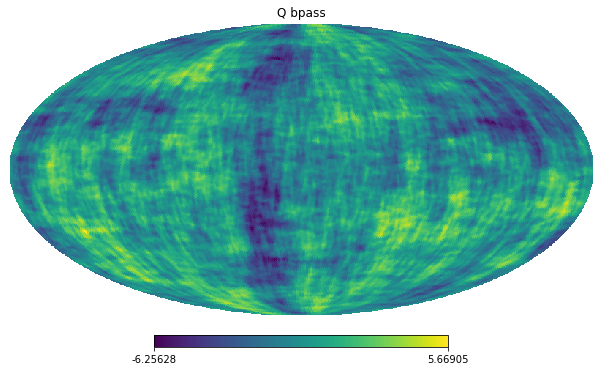

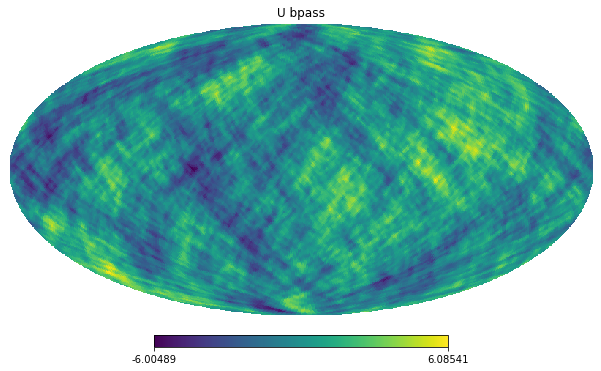

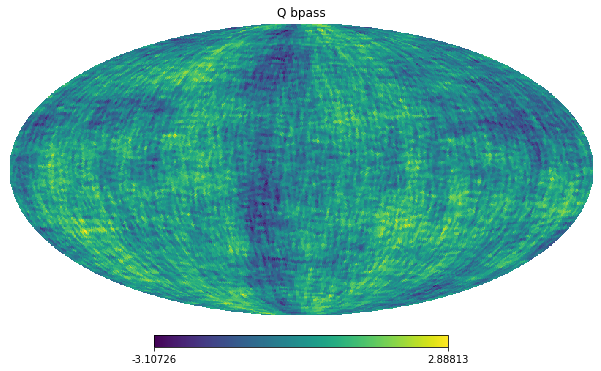

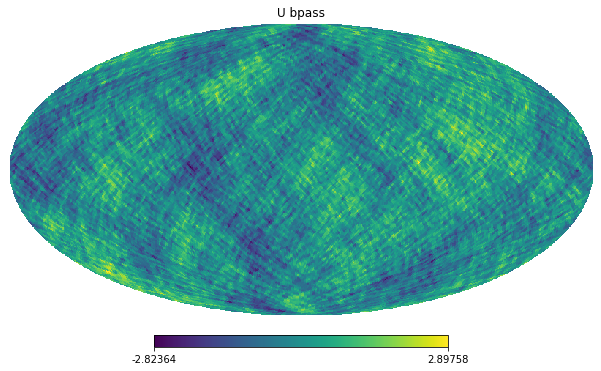

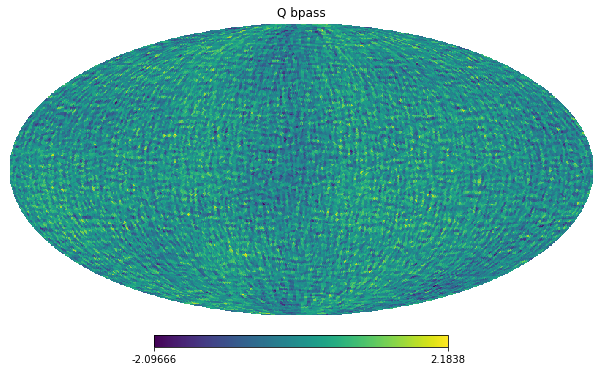

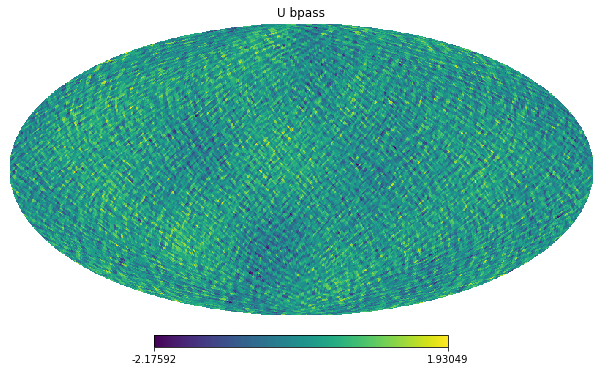

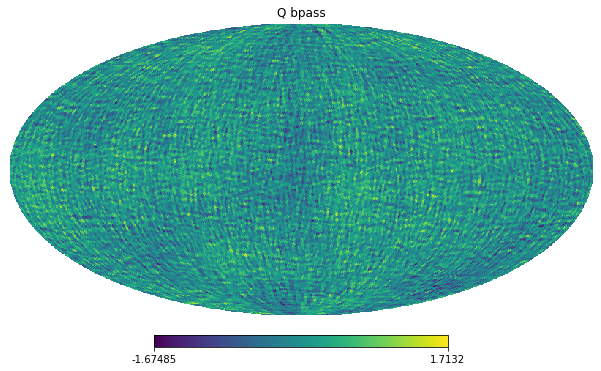

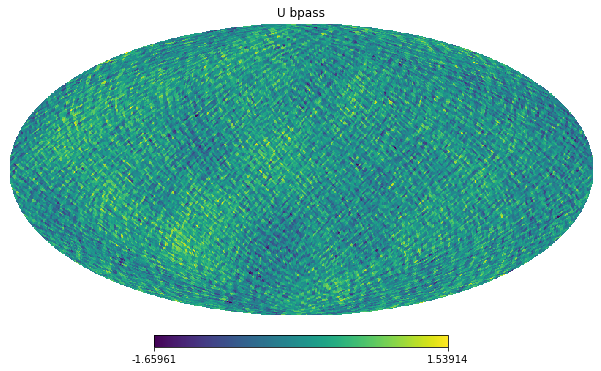

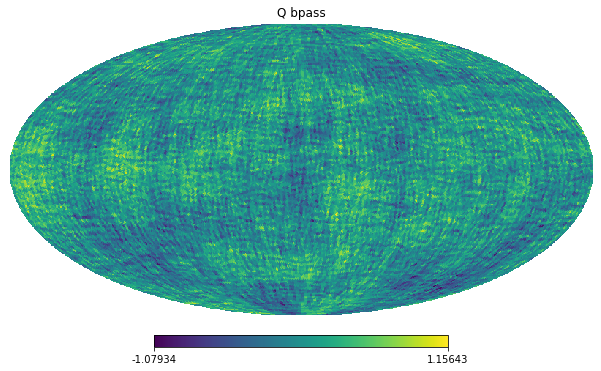

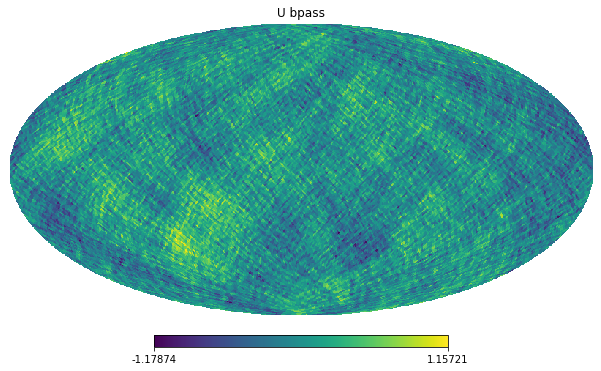

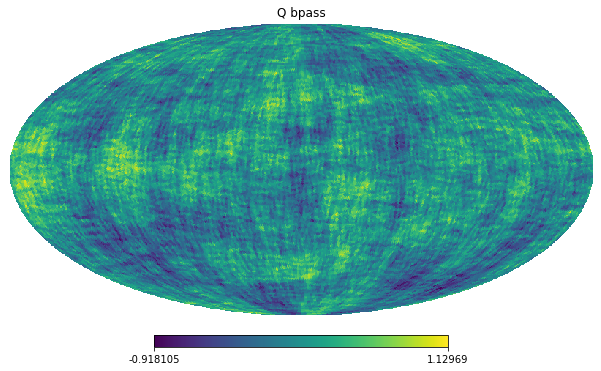

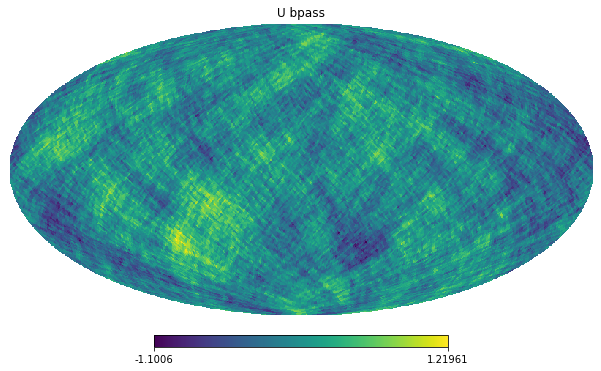

In [66]:
for q,u in sky_maps:
    hp.mollview(q, title="Q bpass")
    hp.mollview(u, title="U bpass")

plt.show()

### Generate mask

In [67]:
npix = hp.nside2npix(nside) # number of pixels for the given nside

nhits=hp.ud_grade(hp.read_map("norm_nHits_SA_35FOV.fits",verbose=False),nside_out=nside)
nhits/=np.amax(nhits) # equiv to nhits = nhits / np.amax(nhits) #np.amax --> max of array nhits
fsky=np.mean(nhits) # mean value of array nhits

The number of frequencies:

In [68]:
nfreqs  = len(nu) 

Set to zero everything outside what is observed in mask:

In [69]:
nhits_binary=np.zeros_like(nhits) # array of zeros w/ same length as nhits
inv_sqrtnhits=np.zeros_like(nhits) # //
inv_sqrtnhits[nhits>1E-3]=1./np.sqrt(nhits[nhits>1E-3]) #inv_sqrtnhits = 1/(Nhits)^0.5 for nhits > 10^-3
nhits_binary[nhits>1E-3]=1 

### Generate noise maps and splits

As it is currently calculated with PySM, the power spectrum of the observed map is convolved with the beam. If we add the noise component, in Fourier space the power spectrum of the observed map is:
\begin{equation*}
a^{obs}_{\ell m} = a_{\ell m} b_{\ell} + N_{\ell m}
\end{equation*}
where $a_{\ell m}$ is the power spectrum of the signal computed $C_{\ell}$ convolved with the beam $b_{\ell}$ and $N_{\ell m}$ is the map of the noise $N_{\ell}$. Eventually we want to obtain the signal deconvolved from the beam and the noise:
\begin{equation*}
\tilde{a}^{obs}_{\ell m} = a_{\ell m} + \frac{n_{\ell m}}{b_{\ell}} 
\end{equation*}
where $\frac{n_{\ell m}}{b_{\ell}} = \tilde{n}_{\ell m}$ is the map of the noise deconvolved from the beam, i.e. $\tilde{N}_{\ell} = \frac{N_{\ell}}{b_{\ell}^2}$, which is what we calculate now.

To generate a map of the noise we use `Simons_Observatory_V3_SA_noise()` as defined in the module `noise_calc` in `BBPipe`. 
First, we set a value to the the parameters

In [70]:
ylf=1
nside=nside
sens=1
knee=1
nsplits=4 #TODs divided in 4 splits

Then we add the noise $N_{\ell}$ 

In [71]:
nell=np.zeros([nfreqs,lmax+1])
_,nell[:,2:],_=Simons_Observatory_V3_SA_noise(sens,knee,ylf,fsky,lmax+1,1,include_kludge=False)

To deconvolve the noise from the beam, first we transform the beams (`Simons_Observatory_V3_SA_beams()`) that were in arcmin into radians by multiplying the beam with the conversion factor $\frac{\pi}{180 \cdot 60}$. Then we define the gaussian beam in radians as $\sigma_G = \frac{beam \ [rad]}{2.355}$, and we calculate the beam $b_{\ell}$ in radians. Finally, we divide the noise by the beam. 

The noise deconvolved from the beam:

In [72]:
for i,(n,b) in enumerate(zip(nell,beams)):
    sig = b * np.pi/180./60/2.355 # turns beam b into sigma, b*pi/180/60 transform beam into rad, 
    bl = np.exp(-sig**2*ells*(ells+1)) # beam in Fourier space
    n *= bl # Remove beam

    n[:2]=n[2] # Fill to ell=0 

The Time Ordered Data (TOD) is divided in 4 splits; each split corresponds to a map $m$, which can be expressed as
\begin{equation*}
m_i = s + n_i
\end{equation*}
where the number of split is $i = [1,2,3,4]$, $s$ is the signal previously computed with PySM (which is the same throughout each split) and $n_i$ is the noise component $N_{\ell}$ of each split.

Noise maps are then generated with `hp.synfast` from $n_i$ at each frequency for each split. The overall noise decreases with the number of splits $n_{splits}$ as described by the standard deviation of noise
\begin{equation}
\sigma_{n} \sim \frac{\sqrt{n_{splits}}}{N_{\ell} \cdot n_{splits} }
\end{equation}
therefore the map of the overall noise at each split is calculated as
\begin{equation*}
N_{\ell} = n_i \cdot \frac{n_{splits}}{\sqrt{n_{hits}}} 
\end{equation*}

In [73]:
noimaps = np.zeros([nsplits,nfreqs,2,npix]) # only noise component changes

for s in range(nsplits):
    for f in range(nfreqs):
        noimaps[s,f,0,:]=hp.synfast(nell[f] * nsplits, nside, pol=False, verbose=False, new=True) * inv_sqrtnhits
        noimaps[s,f,1,:]=hp.synfast(nell[f] * nsplits, nside, pol=False, verbose=False, new=True) * inv_sqrtnhits
#noi_coadd = np.mean(noimaps, axis=0)

print(sky_maps.shape,noimaps.shape)
for s in range(nsplits):
    hp.write_map(prefix_out+"/obs_split%dof%d.fits.gz" % (s+1, nsplits),
                 ((sky_maps[:,:,:]+noimaps[s,:,:,:])*nhits_binary).reshape([nfreqs*2,npix]),
                 overwrite=True)

for f in range(nfreqs):
    np.savetxt(prefix_out + "/cls_noise_b%d.txt" % (f+1),np.transpose([ells,nell[f]]))

'''
# Write splits list
f=open(prefix_out+"/splits_list.txt","w")
stout=""
for i in range(nsplits):
    stout += prefix_out+'/obs_split%dof%d.fits.gz\n' % (i+1, nsplits)
f.write(stout)
f.close()
'''              

plt.show()

(6, 2, 49152) (4, 6, 2, 49152)
